This data has been gathered at two solar power plants in India over a 34 day period. It has two pairs of files - each pair has one power generation dataset and one sensor readings dataset. The power generation datasets are gathered at the inverter level - each inverter has multiple lines of solar panels attached to it. The sensor data is gathered at a plant level - single array of sensors optimally placed at the plant.

There are a few areas of concern at the solar power plant -

#### Can we predict the power generation for next couple of days? - this allows for better grid management
While analyzing data, do we see some patterns in power generation?
#### Can we identify the need for panel cleaning/maintenance?
Is sth working badly or does performance seem to be compromised?
Maybe sth related to the fact, that the temperature and sunlight seems to be lower in June than in May, but I would expect the opposite.
#### Can we identify faulty or suboptimally performing equipment?
Probably some inverters need to be fixed, because there is missing information in 4 different inverters during 9 days.
OR maybe they were being maintenanced...? Can't know that, so would assume that it is not the case

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [419]:
generation_data = pd.read_csv("Plant_2/Plant_2_Generation_Data.csv")
weather_sensor_data = pd.read_csv("Plant_2/Plant_2_Weather_Sensor_Data.csv")
#weather_sensor_data = pd.DataFrame(weather_sensor_data)

In [421]:
# GENERATION DATA

generation = generation_data.drop("PLANT_ID", axis=1)
#generation["SOURCE_KEY"].value_counts().unique()
for i in range(len(generation)):
    generation["DATE_TIME"][i] = datetime.strptime(generation["DATE_TIME"][i], '%Y-%m-%d %H:%M:%S')

# SOURCE_KEY - Source key in this file stands for the inverter id.

# DC_POWER - Amount of Direct Current power generated by the inverter (source_key) in this 15 minute interval. Units - kW.
# AC_POWER - Amount of Alternating Current power generated by the inverter (source_key) in this 15 minute interval. In kW.

# DAILY_YIELD - Daily yield is a cumulative sum of power generated on that day, till that point in time.
# TOTAL_YIELD - This is the total yield for the inverter till that point in time.
    
generation

<ipython-input-421-4f6e9da9b2d2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  generation["DATE_TIME"][i] = datetime.strptime(generation["DATE_TIME"][i], '%Y-%m-%d %H:%M:%S')


,DATE_TIME,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,2020-05-15 00:00:00,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06
1,2020-05-15 00:00:00,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09
2,2020-05-15 00:00:00,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09
3,2020-05-15 00:00:00,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06
4,2020-05-15 00:00:00,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07
...,...,...,...,...,...,...
67693,2020-06-17 23:45:00,q49J1IKaHRwDQnt,0.0,0.0,4157.000000,5.207580e+05
67694,2020-06-17 23:45:00,rrq4fwE8jgrTyWY,0.0,0.0,3931.000000,1.211314e+08
67695,2020-06-17 23:45:00,vOuJvMaM2sgwLmb,0.0,0.0,4322.000000,2.427691e+06
67696,2020-06-17 23:45:00,xMbIugepa2P7lBB,0.0,0.0,4218.000000,1.068964e+08


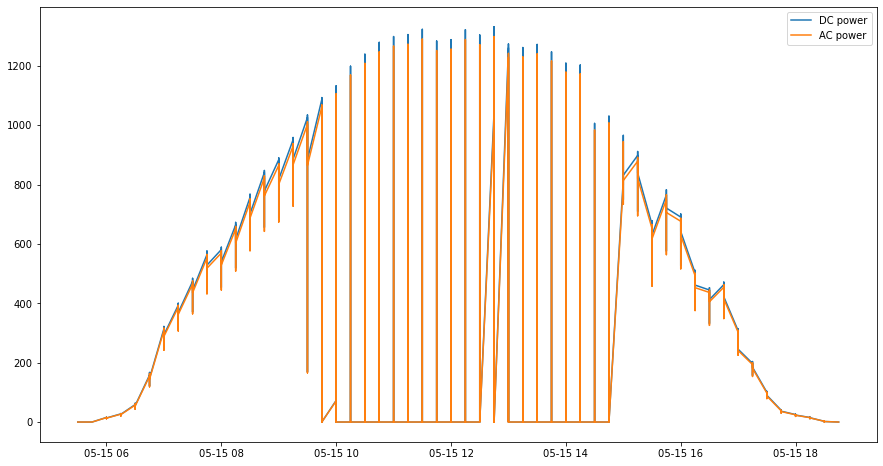

In [458]:
# One day of active DC and AC power data (before 5:45 and after 18:30 the value are zero)

date = generation["DATE_TIME"]
time = date.dt.time
DC = generation["DC_POWER"]
AC = generation["AC_POWER"]
daily = generation["DAILY_YIELD"]
total = generation["TOTAL_YIELD"]

plt.figure(figsize=(15,8))
plt.plot(date[500:1660], DC[500:1660],  label="DC power")
plt.plot(date[500:1660], AC[500:1660],  label="AC power")
plt.legend()
plt.show()

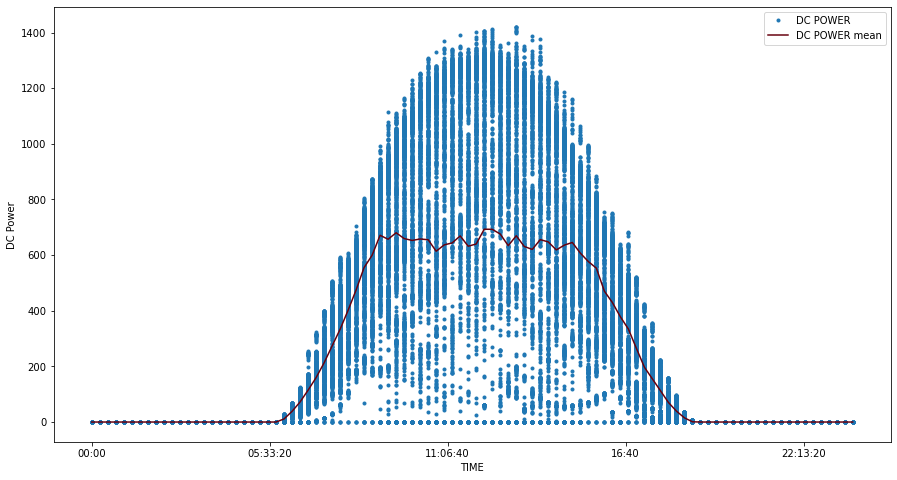

In [461]:
# DC power for each day and the mean
# Also plotted the similar AC power graph, but it was basically the same, as also seen above

generation["TIME"] = generation['DATE_TIME'].dt.time

generation.plot(x="TIME", y="DC_POWER", style='.', figsize = (15, 8), label="DC POWER")
generation.groupby("TIME")["DC_POWER"].agg('mean').plot(legend=True, colormap='Reds_r', label="DC POWER mean")
plt.ylabel('DC Power')
plt.show()

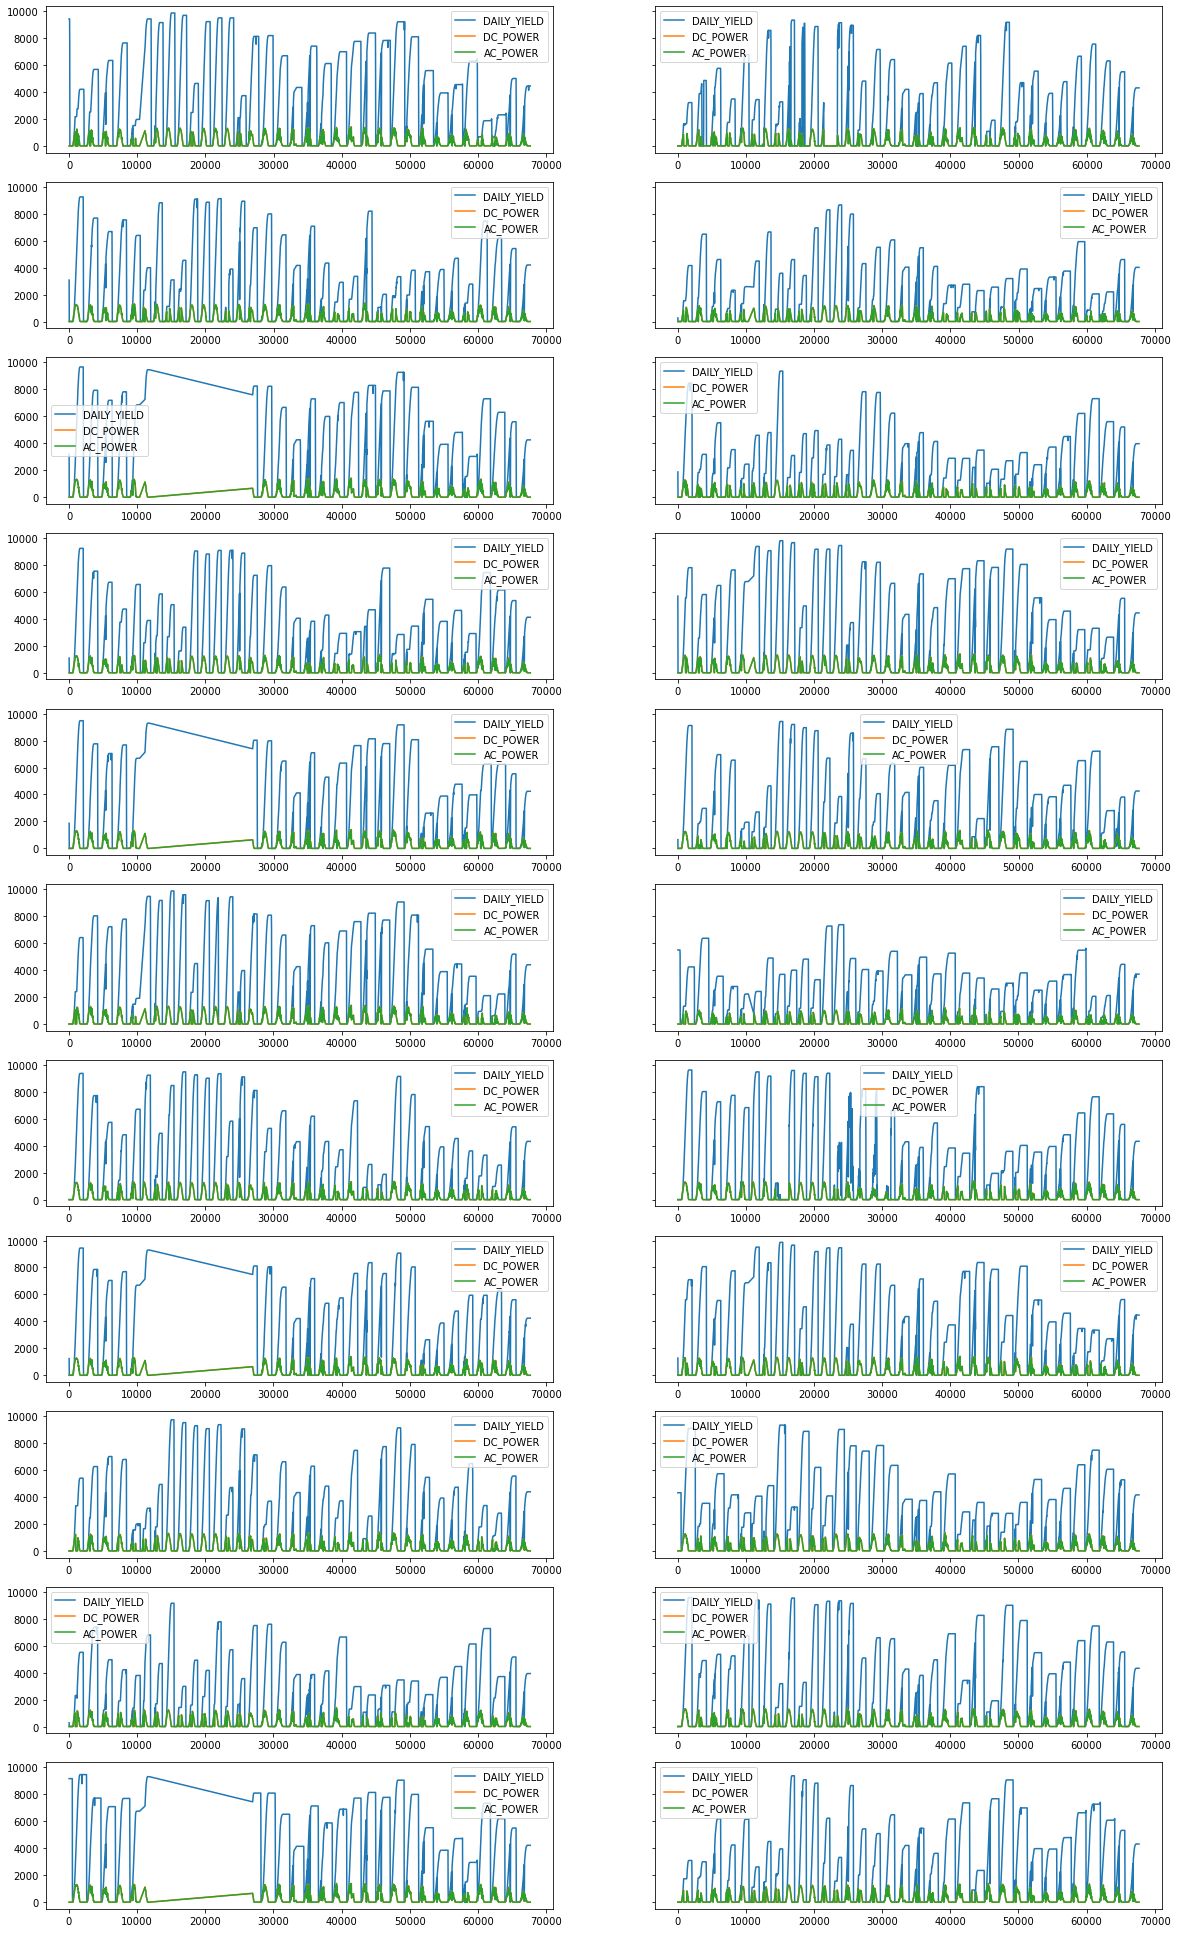

In [432]:
# Different features on different inverters (identified via the source key)
# There are 22 inverters
grouped = generation[["DAILY_YIELD","DC_POWER","AC_POWER","SOURCE_KEY"]].groupby("SOURCE_KEY")

ncols=2
nrows = int(np.ceil(grouped.ngroups/ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,35), sharey=True)
for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot(ax=ax)

ax.legend()
plt.show()
# DC and AC power values overlap quite a lot, which is why the orange line is not seen (hidden behind the green line)

# A few inverters (4 in the graph) seem to have some sort of an issue, because their readings are totally different at times
# OOOR the information is missing

In [433]:
# Let's look at one individual inverter ("4UPUqMRk7TRMgml") 
# (the first inverter)
inverter1 = generation[generation["SOURCE_KEY"]=="4UPUqMRk7TRMgml"]
#inverter1 # 3195 rows
inv_date = inverter1["DATE_TIME"]

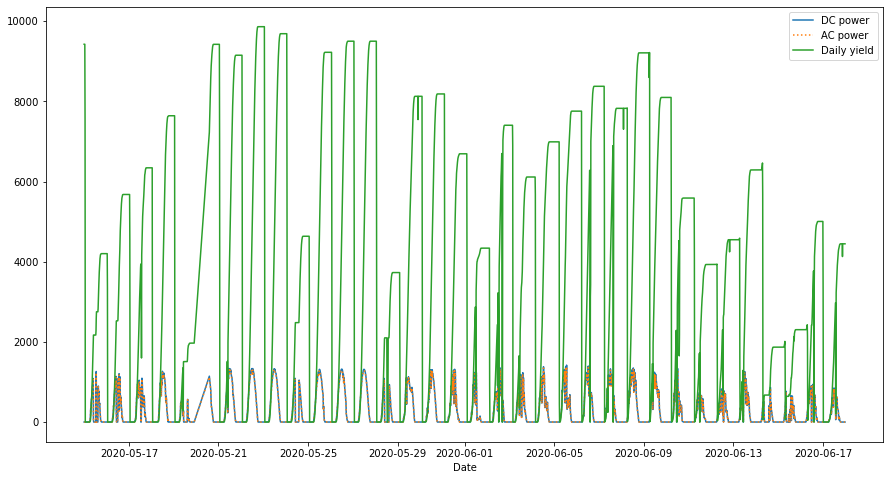

In [502]:
# Daily power generation for the first inverter

plt.figure(figsize=(15, 8))
plt.plot(inv_date, inverter1["DC_POWER"], label="DC power")
plt.plot(inv_date, inverter1["AC_POWER"], linestyle=":", label="AC power")
plt.plot(inv_date, inverter1["DAILY_YIELD"], label="Daily yield")
plt.xlabel("Date")
plt.legend()
plt.show()

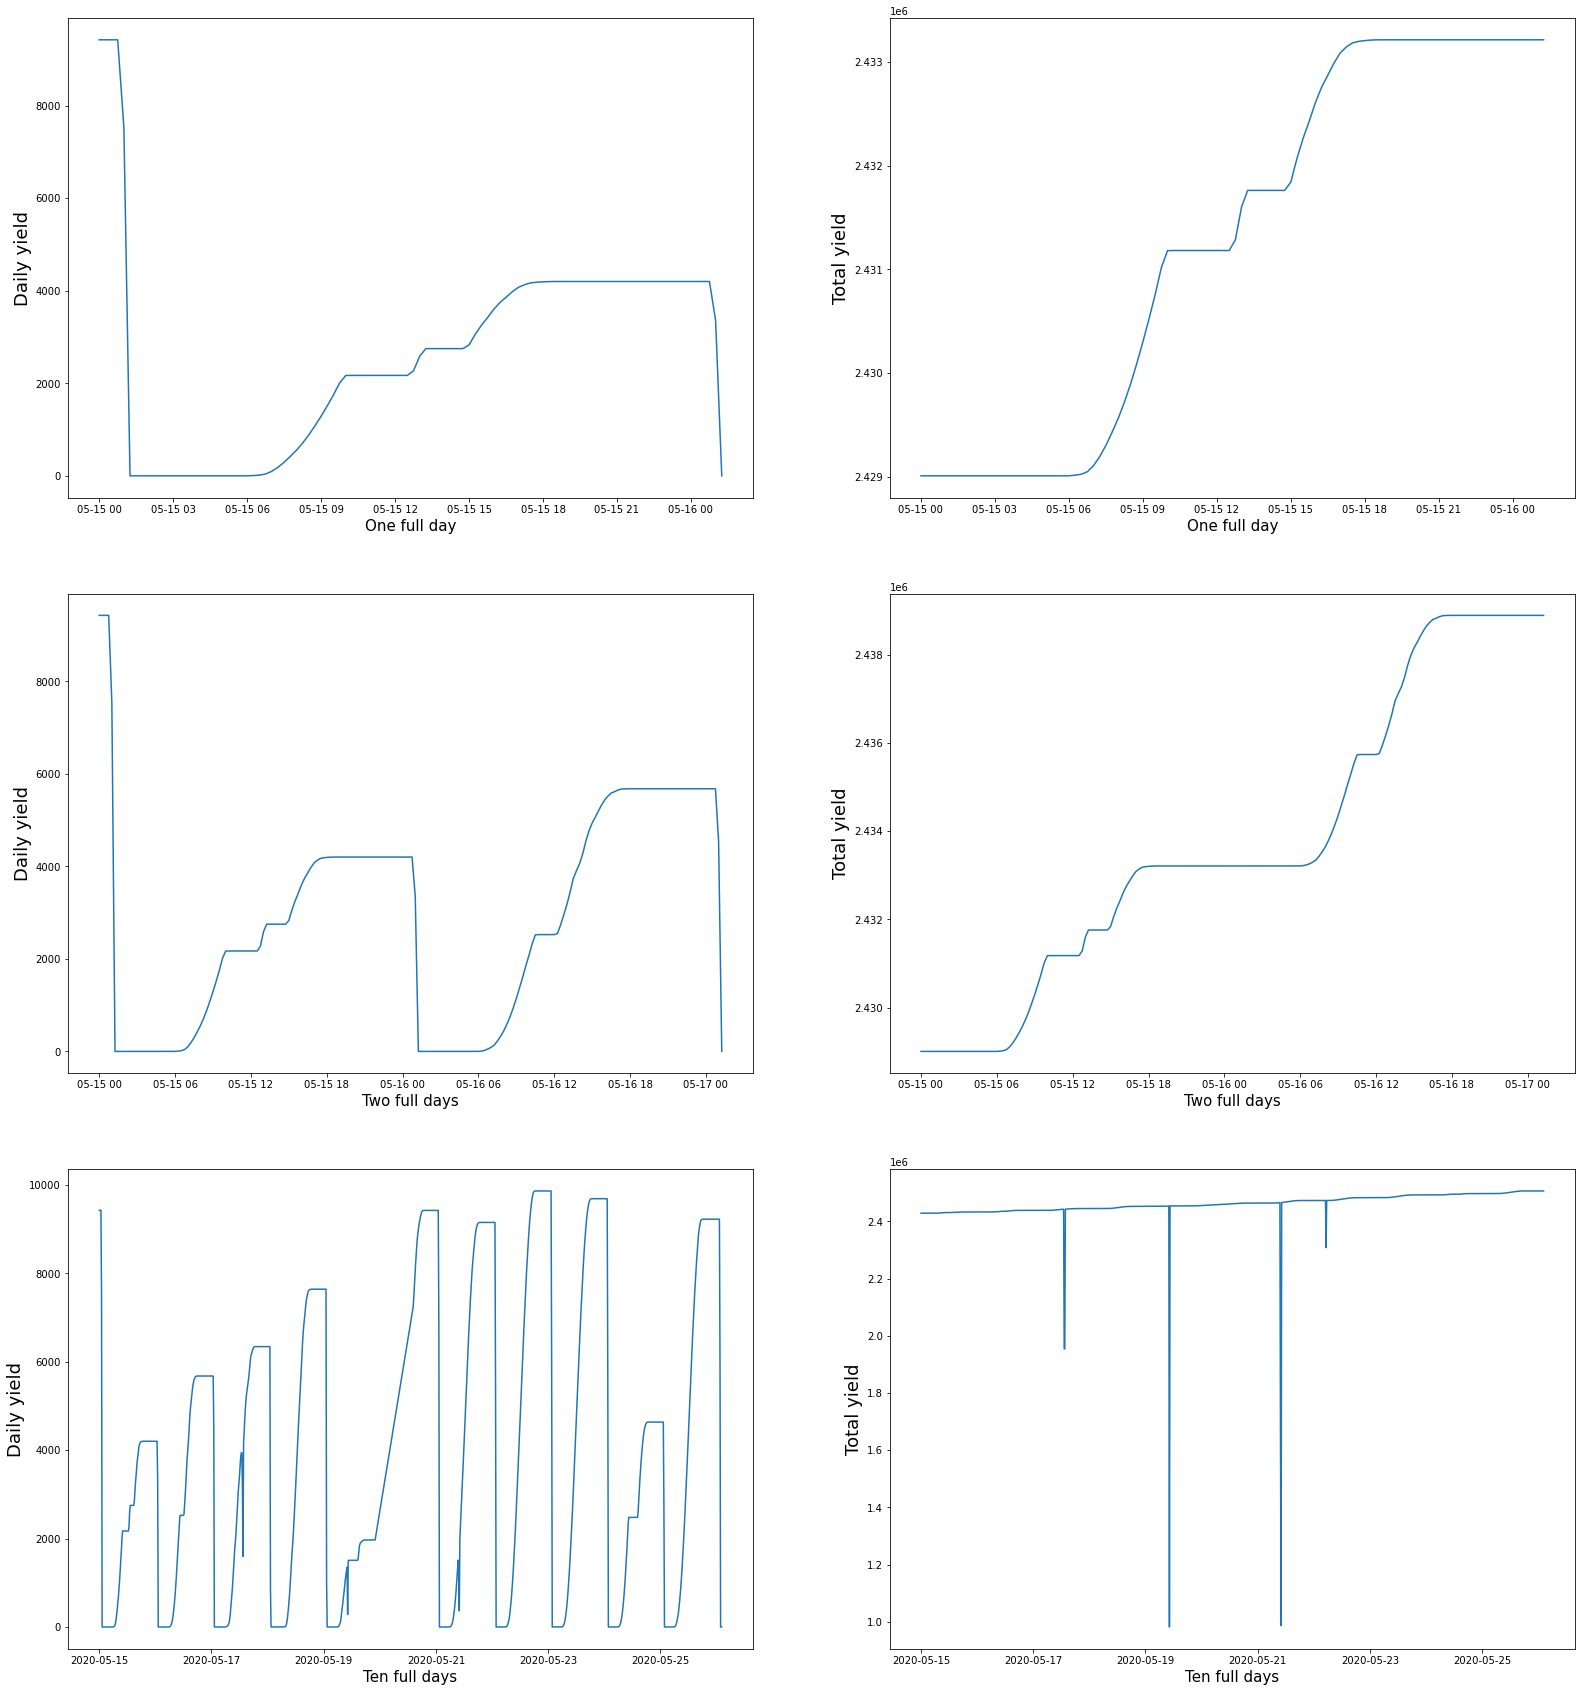

In [449]:
# The first inverters yield data (daily and total) for 1, 2 and 10 days (in order to see if there are any patterns)
plt.figure(figsize=(27,30))

plt.subplot(3,2,1)
plt.plot(inv_date[:101], inverter1["DAILY_YIELD"][:101])
plt.ylabel("Daily yield", size=18)
plt.xlabel("One full day", size=15)

plt.subplot(3,2,2)
plt.plot(inv_date[:101], inverter1["TOTAL_YIELD"][:101])
plt.ylabel("Total yield", size=18)
plt.xlabel("One full day", size=15)

plt.subplot(3,2,3)
plt.plot(inv_date[:197], inverter1["DAILY_YIELD"][:197])
plt.ylabel("Daily yield", size=18)
plt.xlabel("Two full days", size=15)

plt.subplot(3,2,4)
plt.plot(inv_date[:197], inverter1["TOTAL_YIELD"][:197])
plt.ylabel("Total yield", size=18)
plt.xlabel("Two full days", size=15)


plt.subplot(3,2,5)
plt.plot(inv_date[:1000],inverter1["DAILY_YIELD"][:1000])
plt.ylabel("Daily yield", size=18)
plt.xlabel("Ten full days", size=15)

plt.subplot(3,2,6)
plt.plot(inv_date[:1000],inverter1["TOTAL_YIELD"][:1000])
plt.ylabel("Total yield", size=18)
plt.xlabel("Ten full days", size=15)

plt.show()
# The second two pictures (below) show Yield data for two days (specifically 15.05 00:00:00 - 17.05 01:15:00 so 48.25h)
# the end time is chosen so that the daily yield sets to zero again

# From the second row we can see a kind of a pattern, but when looking at a bigger time window, 
# then the pattern isn't exactly the same for each day and differes . However it is similar

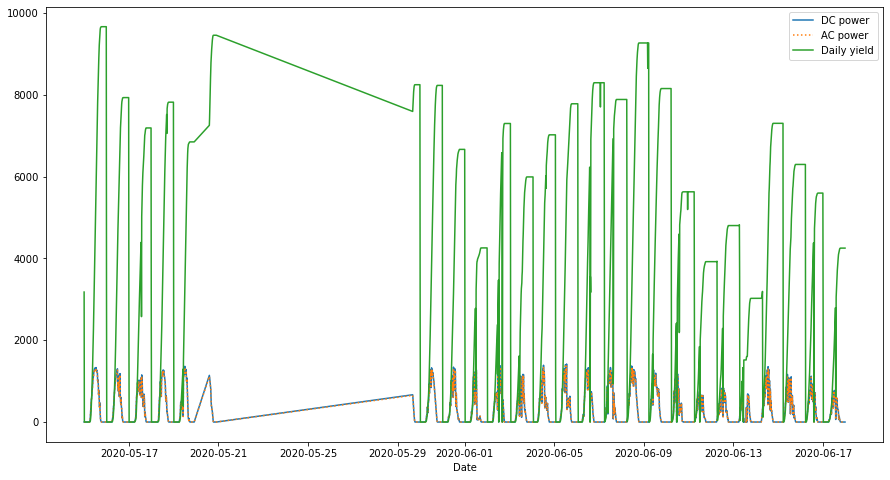

In [501]:
# Example of one problematic inverter, where there seems to be missing information
# from day 21.05 until 29.05, so altogether 9 days and also the same goes for 3 other inverters

inverterX = generation[generation["SOURCE_KEY"]=="IQ2d7wF4YD8zU1Q"]
inv_dateX = inverterX["DATE_TIME"]

plt.figure(figsize=(15, 8))
plt.plot(inv_dateX, inverterX["DC_POWER"], label="DC power")
plt.plot(inv_dateX, inverterX["AC_POWER"], linestyle=":", label="AC power")
plt.plot(inv_dateX, inverterX["DAILY_YIELD"], label="Daily yield")
plt.xlabel("Date")
plt.legend()
plt.show()

In [112]:
# WEATHER SENSOR DATA

weather = weather_sensor_data[["DATE_TIME", "AMBIENT_TEMPERATURE", "MODULE_TEMPERATURE", "IRRADIATION"]]
for i in range(len(weather)):
    weather["DATE_TIME"][i] = datetime.strptime(weather["DATE_TIME"][i], '%Y-%m-%d %H:%M:%S')

# AMBIENT_TEMPERATURE - This is the ambient temperature at the plant.
# MODULE_TEMPERATURE - There's a module (solar panel) attached to the sensor panel. Temperature reading for that module.
# IRRADIATION - Amount of irradiation for the 15 minute interval.    

weather

<ipython-input-112-d9d2d2138483>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather["DATE_TIME"][i] = datetime.strptime(weather["DATE_TIME"][i], '%Y-%m-%d %H:%M:%S')
C:\Users\krist\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,27.004764,25.060789,0.0
1,2020-05-15 00:15:00,26.880811,24.421869,0.0
2,2020-05-15 00:30:00,26.682055,24.427290,0.0
3,2020-05-15 00:45:00,26.500589,24.420678,0.0
4,2020-05-15 01:00:00,26.596148,25.088210,0.0
...,...,...,...,...
3254,2020-06-17 22:45:00,23.511703,22.856201,0.0
3255,2020-06-17 23:00:00,23.482282,22.744190,0.0
3256,2020-06-17 23:15:00,23.354743,22.492245,0.0
3257,2020-06-17 23:30:00,23.291048,22.373909,0.0


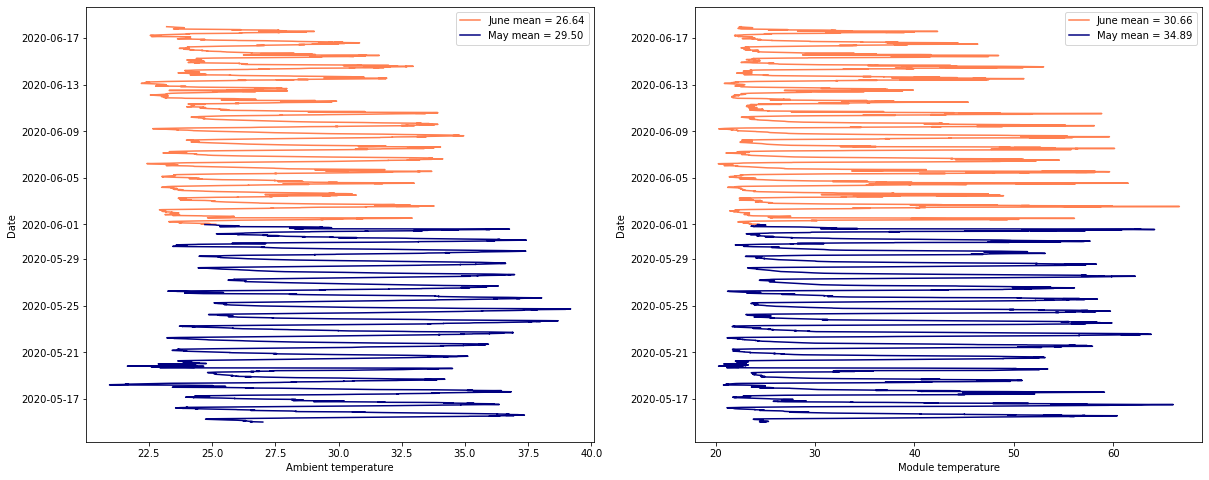

In [246]:
# Temperatures (ambient and module), comparing May and June

dates = weather["DATE_TIME"]
Atemp = weather["AMBIENT_TEMPERATURE"]
M_Atemp = np.round(np.mean(Atemp[:1628]), 2) #29.50
J_Atemp = np.round(np.mean(Atemp[1629:]), 2) #26.64

plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.plot(Atemp[1629:], dates[1629:], color="coral", label="June mean = 26.64")
plt.plot(Atemp[:1628], dates[:1628], color="navy", label="May mean = 29.50")
#plt.figtext(.75, .8, "May mean = 29.50", color="navy")
#plt.figtext(.75, .825, "June mean = 26.64", color="orangered")
plt.xlabel("Ambient temperature")
plt.ylabel("Date")
plt.legend()

Mtemp = weather["MODULE_TEMPERATURE"]
M_Mtemp = np.round(np.mean(Mtemp[:1628]), 2) #34.89
J_Mtemp = np.round(np.mean(Mtemp[1629:]), 2) #30.66

plt.subplot(1,2,2)
plt.plot(Mtemp[1629:], dates[1629:], color="coral", label="June mean = 30.66")
plt.plot(Mtemp[:1628], dates[:1628], color="navy", label="May mean = 34.89")
plt.xlabel("Module temperature")
plt.ylabel("Date")
plt.legend()

plt.legend()
plt.show()

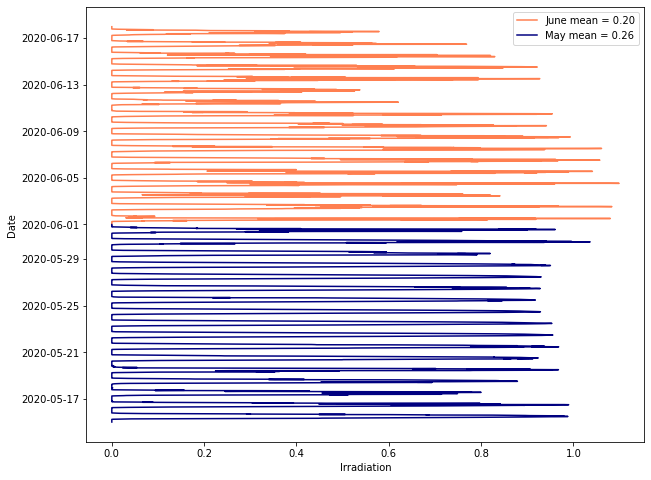

In [237]:
#Irradiation, comparing May and June

datesMAY = weather["DATE_TIME"][:1628]
irradiationMAY = weather["IRRADIATION"][:1628]
mean_irr_M = np.round(np.mean(irradiationMAY), 3) #0.264

datesJUNE = weather["DATE_TIME"][1629:]
irradiationJUNE = weather["IRRADIATION"][1629:]
mean_irr_J = np.round(np.mean(irradiationJUNE), 3) #0.202

plt.figure(figsize=(10, 8))
plt.plot(irradiationJUNE, datesJUNE, color="coral", label="June mean = 0.20")
plt.plot(irradiationMAY, datesMAY, color="navy", label="May mean = 0.26")
#plt.figtext(.76, .8, "May mean = 0.26", color="navy")
#plt.figtext(.76, .825, "June mean = 0.20", color="orangered")
plt.xlabel("Irradiation")
plt.ylabel("Date")
plt.legend()
plt.show()

# From the picture we can see, that oddly enough, June has a lower irradiation mean, 
# however there should be more sun in June